In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import metrics
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

In [2]:
data = pd.read_csv('C:/Users/Srujan/Documents/Datasets/Sunspots.csv',index_col=0,#parse_dates=['Date'],
                   names=['Date','Total_Sunspots'],header=0)
data.tail(100)

,Date,Total_Sunspots
3152,2011-09-30,120.1
3153,2011-10-31,125.7
3154,2011-11-30,139.1
3155,2011-12-31,109.3
3156,2012-01-31,94.4
...,...,...
3247,2019-08-31,0.5
3248,2019-09-30,1.1
3249,2019-10-31,0.4
3250,2019-11-30,0.5


Let's do the analysis on data from 1751 to 2000. That's 250 years.

In [3]:
data = data.loc[(data['Date']>='1751') & (data['Date']<='2001'),['Date','Total_Sunspots']]
data.reset_index(inplace=True)
data.drop('index',axis=1,inplace=True)
data

,Date,Total_Sunspots
0,1751-01-31,116.7
1,1751-02-28,72.5
2,1751-03-31,75.5
3,1751-04-30,94.0
4,1751-05-31,101.2
...,...,...
2995,2000-08-31,180.5
2996,2000-09-30,156.0
2997,2000-10-31,141.6
2998,2000-11-30,158.1


Creating a new column called nth_year where each value in the column is an integer which represents 1 if it is 1st year of the decade or 2 if it is 2nd year of the decade and so on. This column is created to analyze if any seasonality exists in the data for 25 decades.

In [4]:
data['nth_year'] = [str(d)[3] for d in data.Date]
data['nth_year']=data['nth_year'].replace('0','10')
data

,Date,Total_Sunspots,nth_year
0,1751-01-31,116.7,1
1,1751-02-28,72.5,1
2,1751-03-31,75.5,1
3,1751-04-30,94.0,1
4,1751-05-31,101.2,1
...,...,...,...
2995,2000-08-31,180.5,10
2996,2000-09-30,156.0,10
2997,2000-10-31,141.6,10
2998,2000-11-30,158.1,10


Converting date column to datetime object and nth_year to float type.

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data['nth_year'] = data['nth_year'].astype(float)

In the below plot you will see that there is some seasonality. By looking closer we can observe that after every 8-9 years the pattern is repeating. Also we can observe that after a specific period of time the number of sunspots start to decrease and then start to increase.

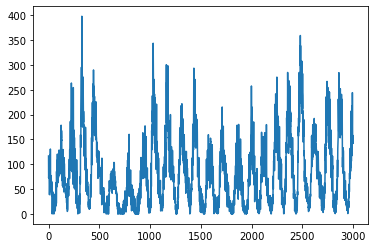

In [6]:
plt.plot(data['Total_Sunspots'])

Extracting year and month from the date column.

In [7]:
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = [d.strftime('%b') for d in data.Date]
data

,Date,Total_Sunspots,nth_year,year,month
0,1751-01-31,116.7,1.0,1751,Jan
1,1751-02-28,72.5,1.0,1751,Feb
2,1751-03-31,75.5,1.0,1751,Mar
3,1751-04-30,94.0,1.0,1751,Apr
4,1751-05-31,101.2,1.0,1751,May
...,...,...,...,...,...
2995,2000-08-31,180.5,10.0,2000,Aug
2996,2000-09-30,156.0,10.0,2000,Sep
2997,2000-10-31,141.6,10.0,2000,Oct
2998,2000-11-30,158.1,10.0,2000,Nov


Now we have to observe the trend and seasonality clearly. For that we use boxlots.

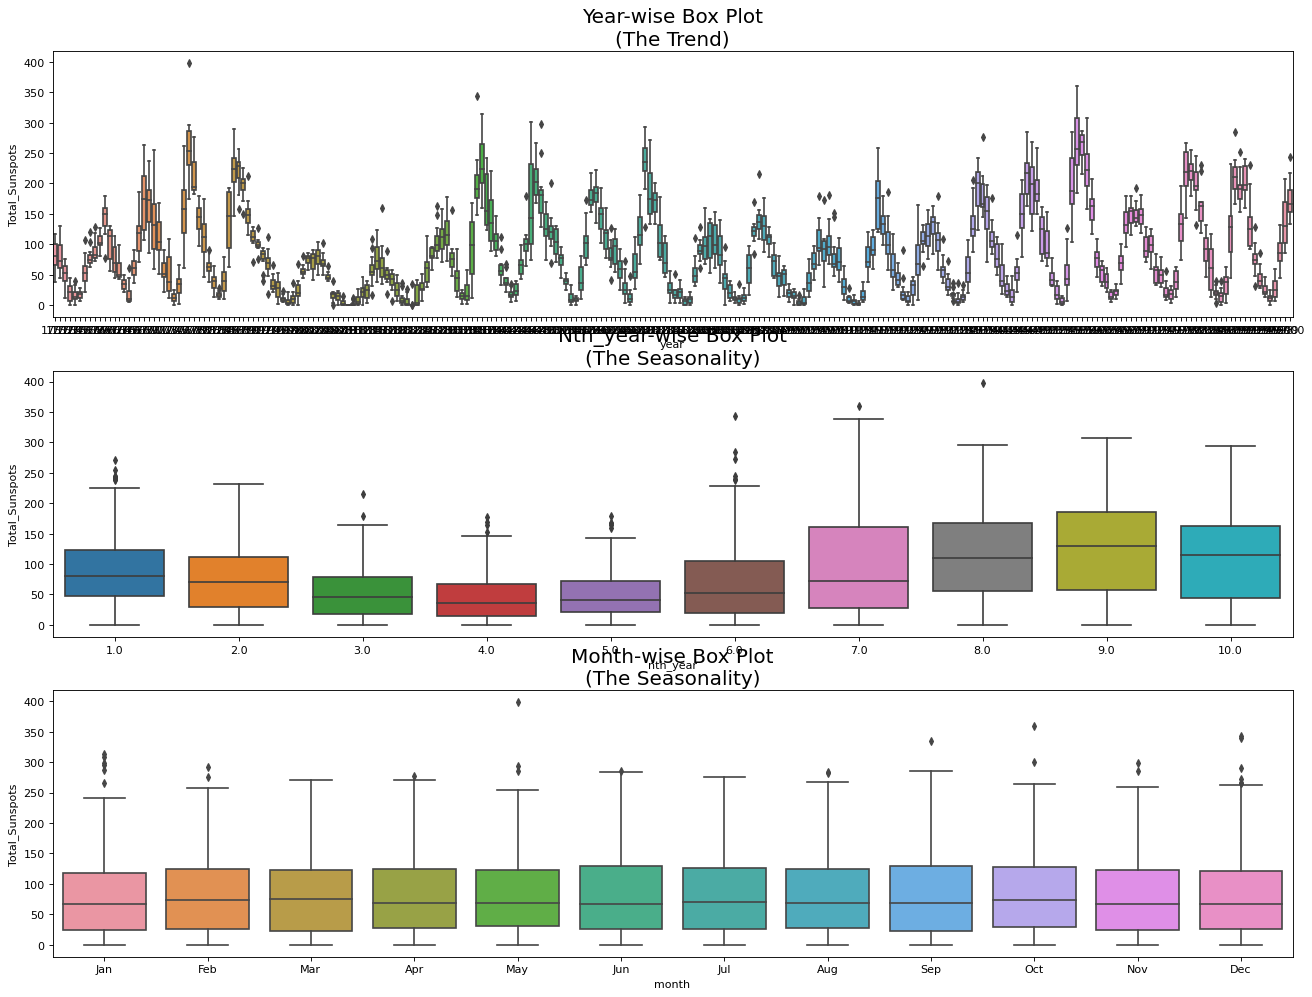

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(20,15), dpi= 80)
sns.boxplot(x='year', y='Total_Sunspots', data=data, ax=axes[0])
sns.boxplot(x='nth_year', y='Total_Sunspots', data=data,ax = axes[1])
sns.boxplot(x='month', y='Total_Sunspots', data=data,ax = axes[2])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 

axes[1].set_title('Nth_year-wise Box Plot\n(The Seasonality)', fontsize=18)

axes[2].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [9]:
data.set_index('Date',inplace=True)

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':


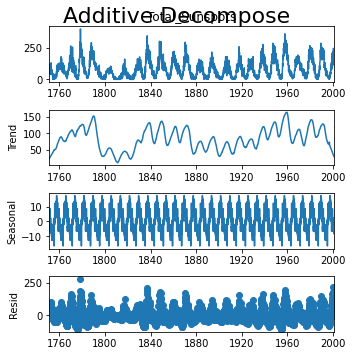

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
# Multiplicative Decomposition 
#result_mul = seasonal_decompose(data['Total_Sunspots'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data['Total_Sunspots'], model='additive', extrapolate_trend='freq',freq=96)

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Detrending Manually

In [11]:
data['rolling_mean'] = data['Total_Sunspots'].rolling(12).mean()
data['Detrend'] = data['Total_Sunspots'] - data['rolling_mean']
data

,Total_Sunspots,nth_year,year,month,rolling_mean,Detrend
Date,,,,,,
1751-01-31,116.7,1.0,1751,Jan,NaN,NaN
1751-02-28,72.5,1.0,1751,Feb,NaN,NaN
1751-03-31,75.5,1.0,1751,Mar,NaN,NaN
1751-04-30,94.0,1.0,1751,Apr,NaN,NaN
1751-05-31,101.2,1.0,1751,May,NaN,NaN
...,...,...,...,...,...,...
2000-08-31,180.5,10.0,2000,Aug,172.233333,8.266667
2000-09-30,156.0,10.0,2000,Sep,176.375000,-20.375000
2000-10-31,141.6,10.0,2000,Oct,174.116667,-32.516667


Text(0.5, 1.0, 'Detrended')

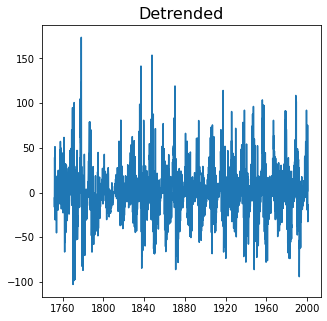

In [12]:
plt.plot(data['Detrend'])
plt.title('Detrended',fontsize=16)

Detrending using seasonal_decompose

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

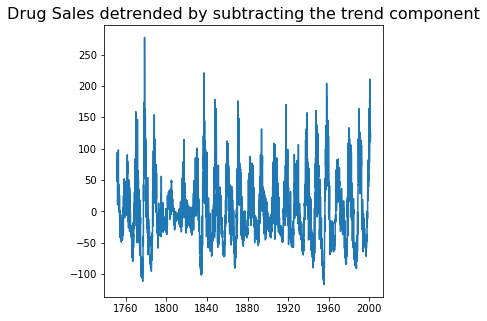

In [13]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(data['Total_Sunspots'], model='add', extrapolate_trend='freq',freq=96)
detrended = data.Total_Sunspots.values -result_add.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

Deseasonalizing using seasonal decompose

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


Text(0.5, 1.0, 'Drug Sales deseasonalized by subtracting the seasonal component')

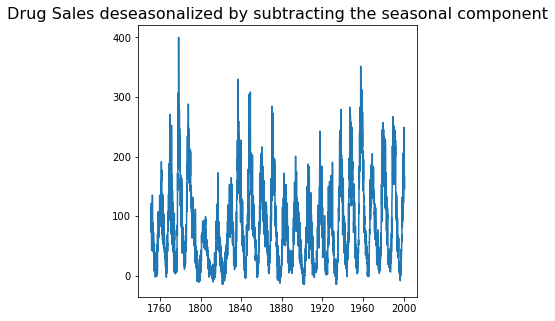

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(data['Total_Sunspots'], model='add', extrapolate_trend='freq',freq=96)
deseasonalized = data.Total_Sunspots.values -result_add.seasonal
plt.plot(deseasonalized)
plt.title('Drug Sales deseasonalized by subtracting the seasonal component', fontsize=16)

Autocorrelation plot

This helps us to find if current value depends on previous values. In the plot you can observe that current value is dependent on previous 110-125 values. This can be around 8-10 years as it is monthly data.

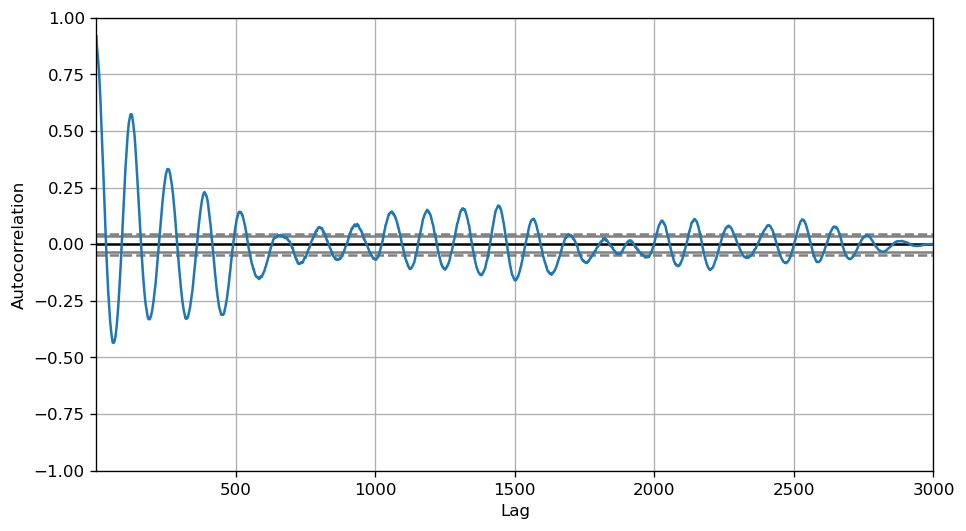

In [15]:
from pandas.plotting import autocorrelation_plot


# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(data['Total_Sunspots'].tolist())

acf plot helps us understand whether the data in additive or multiplicatve in some way. By looking at the plot we can improvise our understanding from above plot and say that present value depends on previous 25-27 values.

pacf plot further says that present value depends only on previous 6 values. All these plots help us narrow down thinking and make our model efficient.

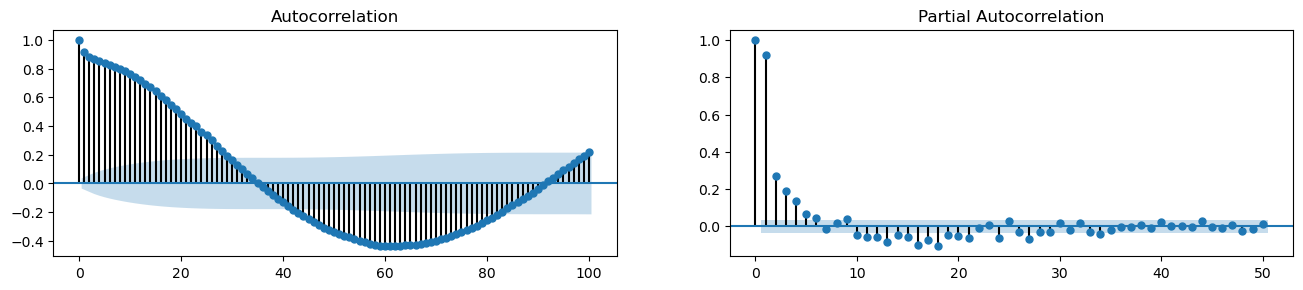

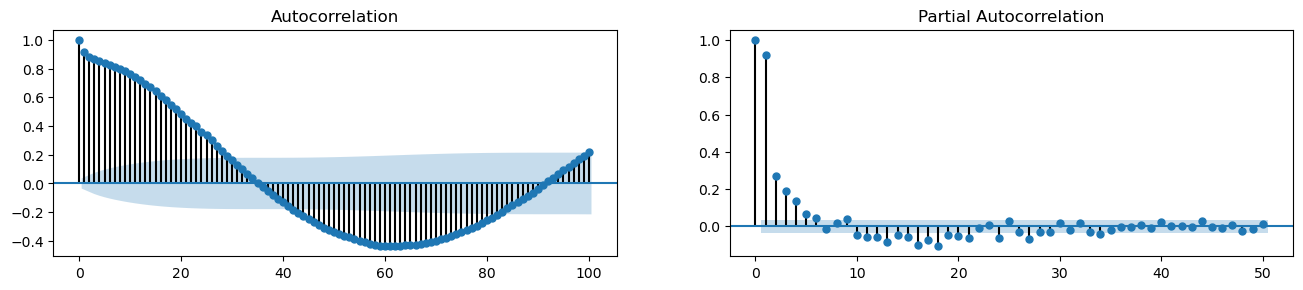

In [16]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['Total_Sunspots'].tolist(), lags=100, ax=axes[0])
plot_pacf(data['Total_Sunspots'].tolist(), lags=50, ax=axes[1])

## Holt Winter's Model

C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


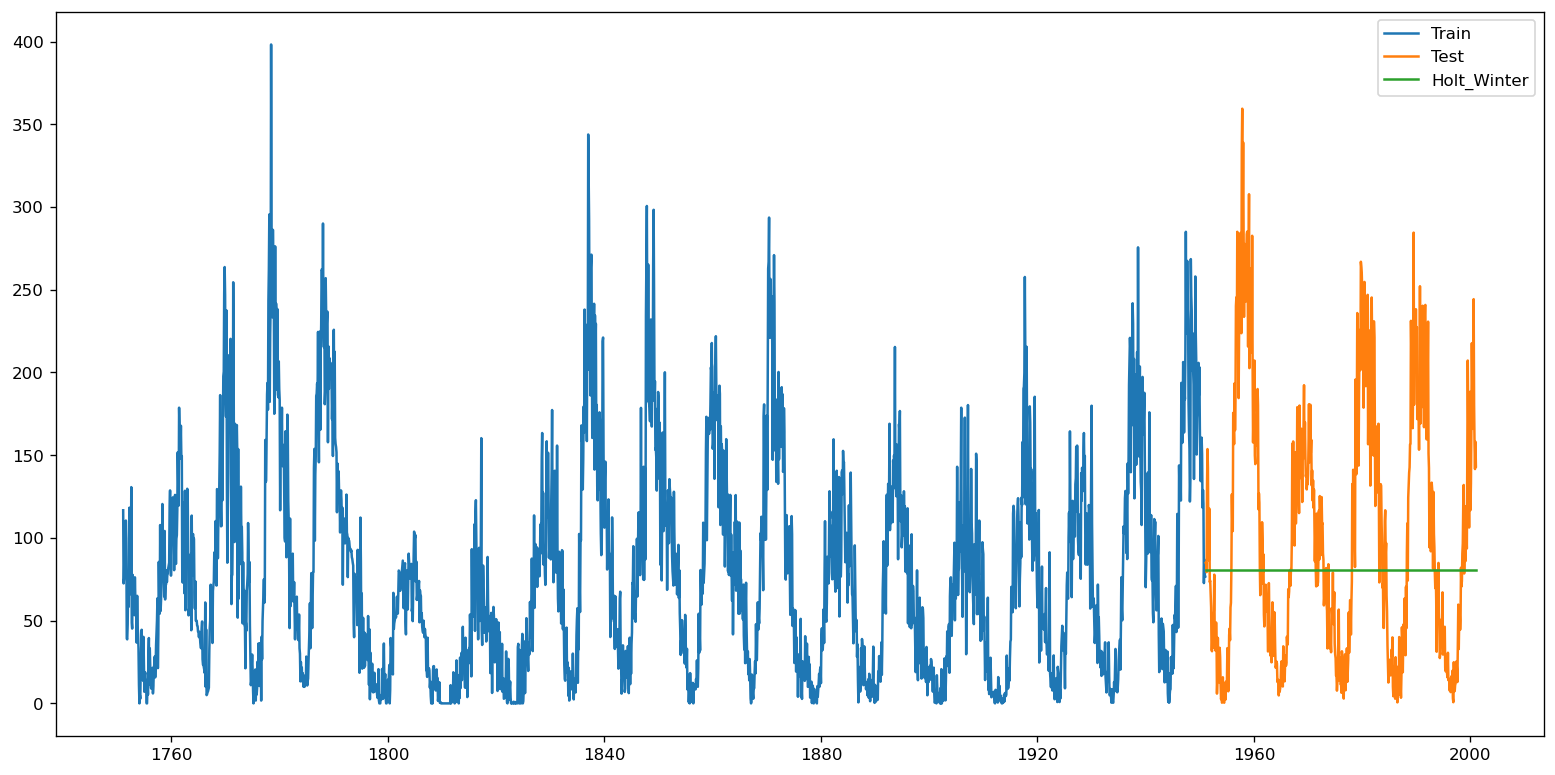

In [17]:
count = int(data.shape[0]*0.8)
Train = data[:count]
Test = data[count:]

y_hat_avg = Test.copy()
fit1 = Holt(np.asarray(Train['Total_Sunspots'])).fit()
y_hat_avg['Holt_Winter'] = fit1.predict(start=count+1,end=data.shape[0])
plt.figure(figsize=(16,8))
plt.plot(Train.index, Train['Total_Sunspots'], label='Train')
plt.plot(Test.index,Test['Total_Sunspots'], label='Test')
plt.plot(y_hat_avg.index,y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
# plt.savefig('Holt_Winters.jpg')

## Holt Winter's using exponential smoothing

Even with exponential smoothing we did not get good predictions.

In [18]:
new = data[['Total_Sunspots']]
new

,Total_Sunspots
Date,
1751-01-31,116.7
1751-02-28,72.5
1751-03-31,75.5
1751-04-30,94.0
1751-05-31,101.2
...,...
2000-08-31,180.5
2000-09-30,156.0
2000-10-31,141.6


C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\Srujan\Anaconda\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


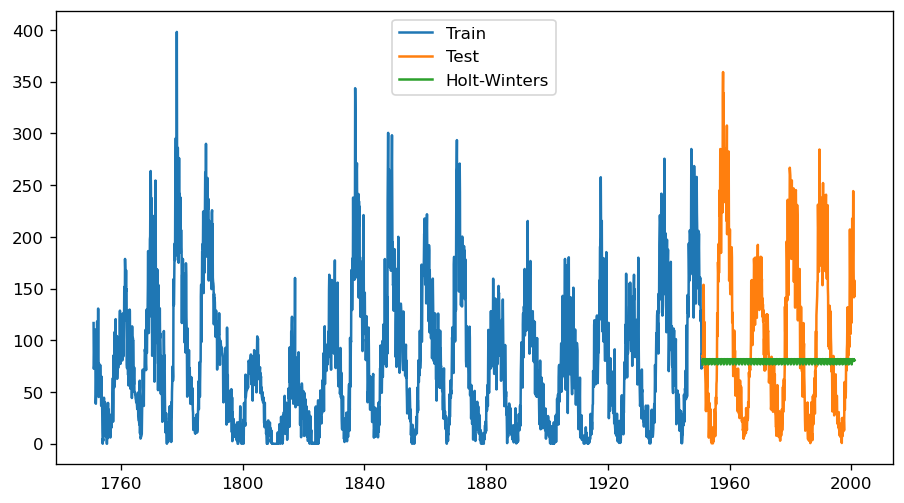

In [19]:
new.index.freq = 'M' # Start of the month
Train, Test = new.iloc[:count, 0], data.iloc[count:, 0]

model = ExponentialSmoothing(Train, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)
pred = hw_model.predict(start=Test.index[0], end=Test.index[-1])

plt.plot(Train.index, Train, label='Train')
plt.plot(Test.index, Test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best');

## ARMA Model

removing the differencing parameter

In [20]:
history = [x for x in Train]

We make a list for training data and we will be predicting next day's closing price with this data. Later the predicted value is appended to training data and next day's value is predicted again. This is repeated for all the test data.

ARIMA's forecast function gives 4 outputs.

predicted value

standard error

lower and upper confidance values which are very important when predicting on time series data.

In [21]:
predictions = []
lower_list = []
upper_list = []
for t in range(len(Test)):
    model = ARIMA(history, order=(5,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    lower = output[2][0][0]
    upper = output[2][0][1]
    predictions.append(yhat)
    lower_list.append(lower)
    upper_list.append(upper)
    obs = Test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=83.083108, expected=85.000000
predicted=85.002644, expected=84.800000
predicted=84.381438, expected=79.300000
predicted=80.858605, expected=131.700000
predicted=110.113054, expected=153.700000
predicted=128.944437, expected=142.400000
predicted=128.728106, expected=87.200000
predicted=101.318429, expected=86.500000
predicted=98.038261, expected=117.700000
predicted=113.630714, expected=73.300000
predicted=88.286565, expected=74.200000
predicted=82.814575, expected=65.000000
predicted=75.457189, expected=57.900000
predicted=67.839484, expected=32.400000
predicted=49.783391, expected=31.500000
predicted=43.930916, expected=41.700000
predicted=46.202189, expected=33.600000
predicted=39.789536, expected=52.000000
predicted=48.102518, expected=56.100000
predicted=51.911070, expected=77.800000
predicted=65.592226, expected=40.400000
predicted=48.234746, expected=34.200000
predicted=42.877813, expected=31.800000
predicted=40.406902, expected=48.900000
predicted=47.976852, expected=3

In [22]:
error = metrics.mean_squared_error(Test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 665.301


The plot in the black color is original test values. The blue one is predicted values. The green and red plots are upper and lower confidance values respecctively.

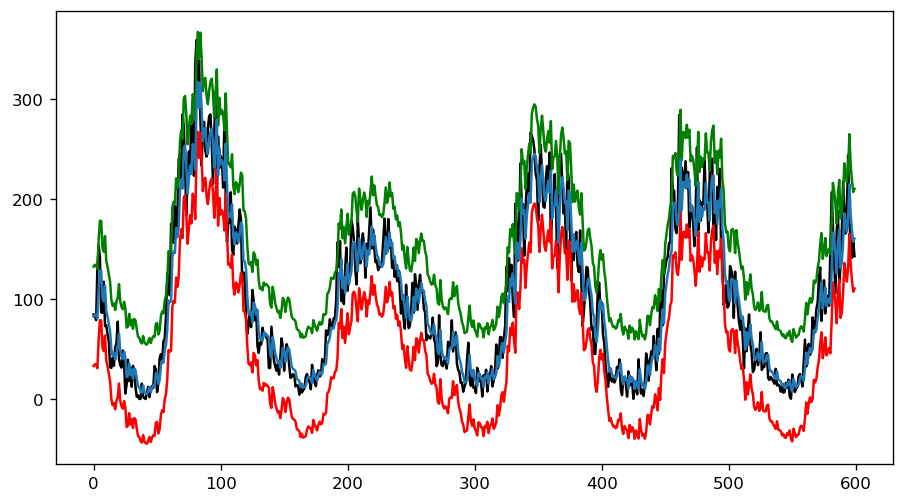

In [23]:
# plot
plt.plot(Test.values,color='black')
plt.plot(lower_list,color='red')
plt.plot(upper_list,color='green')
plt.plot(predictions)
plt.show()